In [ ]:
import torch
from torch import nn, optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import random
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
class CFG:
    num_epochs = 10
    batch_size = 16
    learning_rate = 0.0003
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image_size = 224
    num_classes = 3
    path =  '/content/drive/MyDrive/Image_Blur_Claasification'
    stoi = {'Global_blur': 0, 'Local_Blur': 1, 'No_Blur': 2}
    itos = {0: 'Global_blur', 1: 'Local_Blur', 2: 'No_Blur'}



In [ ]:
# Data transforms
def get_transforms(transforms_type):
    if transforms_type == 'train':
        return transforms.Compose([
            transforms.Resize((CFG.image_size, CFG.image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(30),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=CFG.mean, std=CFG.std)
        ])
    else:
        return transforms.Compose([
            transforms.Resize((CFG.image_size, CFG.image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=CFG.mean, std=CFG.std)
        ])

In [ ]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, data, transforms_type='train'):
        self.data = data
        self.transforms = get_transforms(transforms_type)

    def __getitem__(self, idx):
        filename, classname = self.data[idx]
        image_path = os.path.join(CFG.path, classname, filename)
        image = Image.open(image_path).convert("RGB")
        return self.transforms(image), torch.tensor(CFG.stoi[classname])

    def __len__(self):
        return len(self.data)


In [ ]:
# Split dataset
def split_dataset(path=CFG.path, test_size=0.2, val_size=0.1):
    data = []
    for classname in os.listdir(path):
        if os.path.isdir(os.path.join(path, classname)):
            for filename in os.listdir(os.path.join(path, classname)):
                data.append((filename, classname))
    random.shuffle(data)
    train_data, temp_data = train_test_split(data, test_size=test_size + val_size, stratify=[x[1] for x in data])
    val_data, test_data = train_test_split(temp_data, test_size=val_size / (test_size + val_size), stratify=[x[1] for x in temp_data])
    return train_data, val_data, test_data

train_data, val_data, test_data = split_dataset()

In [ ]:
# Load data and split it
train_data, val_data, test_data = split_dataset()


In [ ]:
# DataLoaders for training, validation, and testing
train_loader = DataLoader(CustomDataset(train_data, transforms_type='train'), batch_size=CFG.batch_size, shuffle=True)
val_loader = DataLoader(CustomDataset(val_data, transforms_type='valid'), batch_size=CFG.batch_size, shuffle=False)
test_loader = DataLoader(CustomDataset(test_data, transforms_type='test'), batch_size=CFG.batch_size, shuffle=False)

In [ ]:
# Model
class BlurClassificationModel(nn.Module):
    def __init__(self):
        super(BlurClassificationModel, self).__init__()
        self.model = models.mobilenet_v2(pretrained=True)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, CFG.num_classes)
        self.model.to(device)

    def forward(self, x):
        return self.model(x)

model = BlurClassificationModel()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=CFG.learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

In [ ]:
# Training and validation loop
best_val_acc = 0.0
for epoch in range(CFG.num_epochs):
    # Training
    model.train()
    train_loss, correct_train, total_train = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_acc = 100 * correct_train / total_train

In [ ]:
# Validation
model.eval()
val_loss, correct_val, total_val = 0, 0, 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()
val_acc = 100 * correct_val / total_val

print(f'Epoch [{epoch+1}/{CFG.num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}')



Epoch [10/10], Train Loss: 0.1231, Train Acc: 96.53, Val Loss: 0.2558, Val Acc: 92.59


In [ ]:
# Save the model with the best validation accuracy
if val_acc > best_val_acc:
    best_val_acc = val_acc
    torch.save(model.state_dict(), 'best_blur_classification_model.pth')
    print("Model saved!")

# Update learning rate
scheduler.step()

Model saved!


In [ ]:
# Load the best model for testing
model.load_state_dict(torch.load('best_blur_classification_model.pth'))
# Test
model.eval()
correct_test, total_test = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
test_acc = 100 * correct_test / total_test
print(f'Test Accuracy: {test_acc:.2f}%')

Test Accuracy: 88.89%


FileUpload(value={}, accept='image/*', description='Upload')


📌 Predicted Class Index: 2
🧠 Predicted Label: No_Blur (Global_blur = 0, Local_Blur = 1, No_Blur = 2)


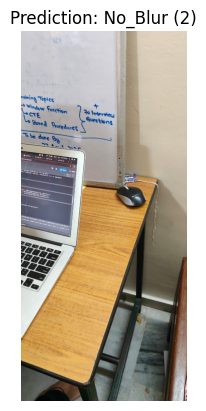


📌 Predicted Class Index: 1
🧠 Predicted Label: Local_Blur (Global_blur = 0, Local_Blur = 1, No_Blur = 2)


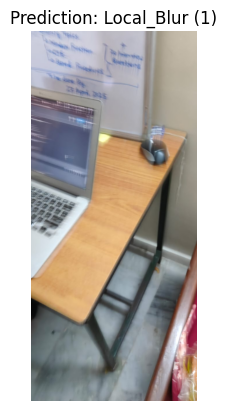


📌 Predicted Class Index: 0
🧠 Predicted Label: Global_blur (Global_blur = 0, Local_Blur = 1, No_Blur = 2)


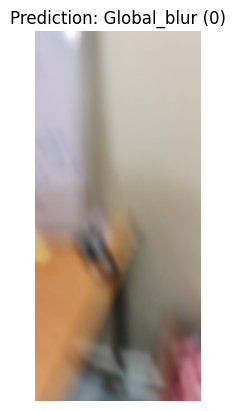

In [ ]:
from ipywidgets import FileUpload
from IPython.display import display
import io
from PIL import Image
import matplotlib.pyplot as plt

# Function to preprocess uploaded image
def preprocess_uploaded_image(image_bytes):
    transform = get_transforms('test')
    image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    return image_tensor, image

# Callback function after upload
def classify_uploaded_image(change):
    if not upload.value:
        print("No image uploaded.")
        return

    for filename, file_info in upload.value.items():
        image_bytes = file_info['content']
        image_tensor, raw_image = preprocess_uploaded_image(image_bytes)

        model.eval()
        with torch.no_grad():
            output = model(image_tensor)
            _, predicted = torch.max(output, 1)
            predicted_label = predicted.item()
            label_name = CFG.itos[predicted_label]

        print(f"\n📌 Predicted Class Index: {predicted_label}")
        print(f"🧠 Predicted Label: {label_name} (Global_blur = 0, Local_Blur = 1, No_Blur = 2)")

        plt.imshow(raw_image)
        plt.title(f"Prediction: {label_name} ({predicted_label})")
        plt.axis('off')
        plt.show()

# Create the file upload widget
upload = FileUpload(accept='image/*', multiple=False)
upload.observe(classify_uploaded_image, names='value')
display(upload)